# CS156 Assignment-5

## Data processing

In [2]:
import pandas as pd
from datetime import datetime

df = pd.read_csv("anonymized.csv")
# convert data string to Python datetime object
df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, '%d%b%Y'))
# split day, month, year into separate column
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df.drop(columns=['Date'], inplace=True)

print (df.head())

     Amount  Day  Month  Year
0  54241.35   25      5  2016
1  54008.83   29      5  2017
2  54008.82   30      6  2017
3  52704.37    5      1  2017
4  52704.36   23      2  2017


## Density model function

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors.kde import KernelDensity

def generate_kde(df, data_label, bins, x_label, show=True, bw=2):
    data = np.array(df[data_label])
    kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(data.reshape(-1, 1))
    
    plt.hist(data, bins=bins, density=True)
    
    d_max = data.max()
    d_min = data.min()
    d_range = d_max - d_min
    x = np.linspace(d_min-d_range//10, d_max+d_range//10, 200).reshape(-1, 1)
    y = np.exp(kde.score_samples(x))
    plt.plot(x, y)
    
    plt.title("Density Estimation of {:s}".format(x_label))
    plt.xlabel(x_label)
    plt.ylabel("Density")
    if show is True:
        plt.show()
    
    return kde

## Number of transactions in a single month

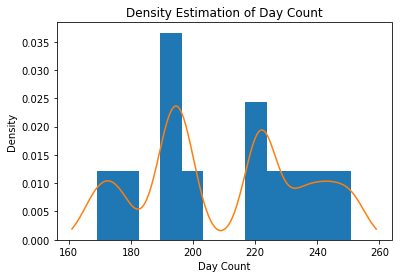

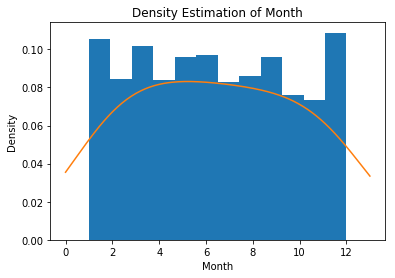

In [4]:
month_count_kde = generate_kde(df.groupby(['Month']).count(), "Amount", 12, "Day Count", bw=5)
month_kde = generate_kde(df, "Month", 12, "Month")

## The day in the month a transaction will occur on

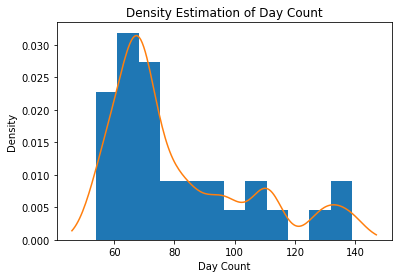

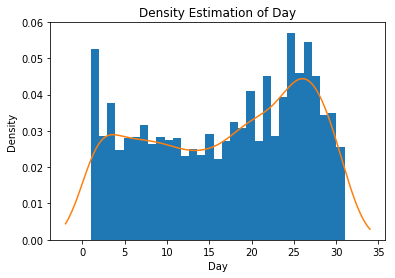

In [5]:
day_count_kde = generate_kde(df.groupby(['Day']).count(), "Amount", 12, "Day Count", bw=5)
day_kde = generate_kde(df, "Day", 31, "Day")

## Transaction size

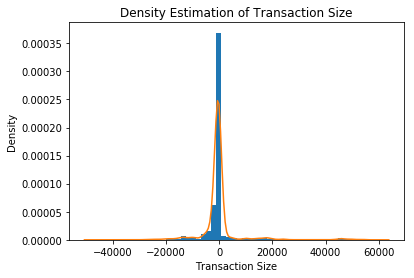

In [6]:
amount_kde = generate_kde(df, "Amount", 50, "Transaction Size", bw=1200)

### The data has a vary large range and discrete distribution, to fit and plot the data better, we will transform the data to log scale.

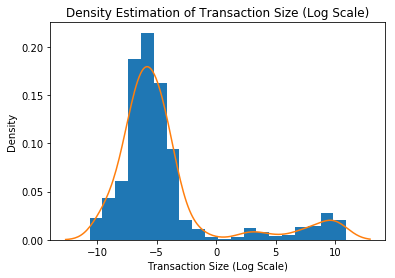

In [7]:
# as in log scale, $1 clapes to 0, we will assign amount less than $1 as 0 in log scale
df['LogAmount'] = list(map(lambda x: (abs(x)>1) * np.log(abs(x)) * (2*(x>0)-1), df['Amount']))

# as the model is in log scale, difference get magnified exponentially
# set bandwidth to a small number to generate a closer fit
log_amount_kde = generate_kde(df, "LogAmount", 20, "Transaction Size (Log Scale)", bw=1)

## Sampling from density models, create a fictitious month of transactions

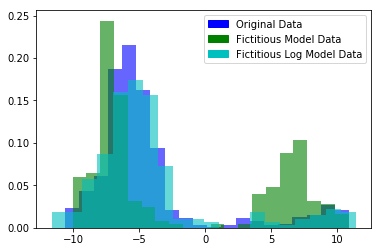

   Day        Amount  LogAmount  AmountFromLog  LogAmountFromLog
0   13  -1676.534752  -7.424484     -47.214721         -3.854706
1   27   1382.266351   7.231480  -27391.019164        -10.217970
2    5   2230.581704   7.710018   -1008.701425         -6.916419
3   30    989.886962   6.897591   -1075.666110         -6.980695
4   26 -10287.080159  -9.238644    -453.231322         -6.116403
5   29  -1973.456675  -7.587542    -258.414037         -5.554563
6    5   9635.611955   9.173221   -4509.393796         -8.413918
7   23   -843.561281  -6.737633    -148.950683         -5.003615
8   25     55.419491   4.014931   -4367.329195         -8.381907
9   31  -1145.743747  -7.043809    3368.368995          8.122184


In [8]:
import matplotlib.patches as mpatches

def fictitious_sample():
    # number of transaction for the fictitious can be determined
    # by sampling from the month count density model
    num_of_transaction = int(month_count_kde.sample())

    # sample from the day density model to obtain the date of each transaction
    # convert the sample to range of 1 to 31 to represent the acctual day
    day_of_transaction = np.clip(np.array(day_kde.sample(num_of_transaction), dtype = 'int').reshape(-1), 1, 31)

    # sample from the log scale transaction amount density model
    # and reproduce the actual transaction amount
    amount_from_log = list(map(lambda x: np.exp(abs(x)) * (2*(x>0)-1),
                               np.array(log_amount_kde.sample(num_of_transaction)).reshape(-1)))
    
    amount = amount_kde.sample(num_of_transaction).reshape(-1)
    
    fictitious_df = pd.DataFrame({
        "Day": day_of_transaction,
        "Amount": amount,
        "LogAmount": list(map(lambda x: (abs(x)>1) * np.log(abs(x)) * (2*(x>0)-1), amount)),
        "AmountFromLog": amount_from_log,
        "LogAmountFromLog": list(map(lambda x: (abs(x)>1) * np.log(abs(x)) * (2*(x>0)-1), amount_from_log))
    })
    
    plt.hist(df['LogAmount'], bins=20, density=True, alpha=0.6, color='b')
    plt.hist(fictitious_df['LogAmount'], bins=20, density=True, alpha=0.6, color='g')
    plt.hist(fictitious_df['LogAmountFromLog'], bins=20, density=True, alpha=0.6, color='c')
    
    plt.legend(handles=[mpatches.Patch(color='b', label='Original Data'),
                        mpatches.Patch(color='g', label='Fictitious Model Data'),
                        mpatches.Patch(color='c', label='Fictitious Log Model Data')])
    plt.show()
    
    return fictitious_df

fictitious_df = fictitious_sample()
print (fictitious_df.head(10))

#### As we can see, the fictitious data sampled from the log-transformed density model perform much better than the data sampled from the direct density model, where the direct model generated a peak at around 5 in the log scale graph that does not exist in the original data. In general, comparing the original data distribution and the fictitious data produced by the log-transformed density model, there is not a significant difference. It is observable that the log-transformed model generates a smother peak on the negative half of the data. However, this can be solved by setting a even smaller bandwath parimater to the density model.

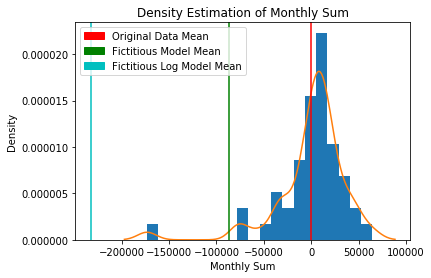

In [9]:
monthly_sum_df = df[['Year', 'Month', 'Amount']].groupby(['Year', 'Month']).sum()
log_amount_kde = generate_kde(monthly_sum_df, "Amount", 20, "Monthly Sum", False, 10000)

plt.axvline(sum(df['Amount']), color='red')
plt.axvline(sum(fictitious_df['Amount']), color='g')
plt.axvline(sum(fictitious_df['AmountFromLog']), color='c')

plt.legend(handles=[mpatches.Patch(color='r', label='Original Data Mean'),
                        mpatches.Patch(color='g', label='Fictitious Model Mean'),
                        mpatches.Patch(color='c', label='Fictitious Log Model Mean')])

plt.show()

#### The log-transformed density model correctly camptured the mean of the original data.

## Benford’s law

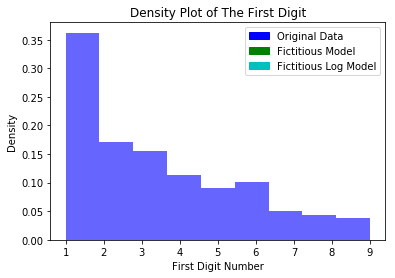

In [12]:
# the smallest amount in the original data is 0.03
# multiple amount by 100 to make every first digit non-zero
data_1st_digit = list(map(lambda x: int(str(abs(x))[:1]), df['Amount']*100))
fictitious_1st_digit = list(map(lambda x: int(str(abs(x))[:1]), fictitious_df['Amount']*100))
fictitious_from_log_1st_digit = list(map(lambda x: int(str(abs(x))[:1]), fictitious_df['AmountFromLog']*100))

plt.hist(data_1st_digit, bins=9, density=True, alpha=0.6, color='b')
plt.hist(fictitious_1st_digit, bins=9, density=True, alpha=0.6, color='g')
plt.hist(fictitious_from_log_1st_digit, bins=9, density=True, alpha=0.6, color='c')

plt.title("Density Plot of The First Digit")
plt.xlabel("First Digit Number")
plt.ylabel("Density")

plt.legend(handles=[mpatches.Patch(color='b', label='Original Data'),
                        mpatches.Patch(color='g', label='Fictitious Model'),
                        mpatches.Patch(color='c', label='Fictitious Log Model')])
    
plt.show()

#### As we can see, the original data, the fictitious data from direct density model, and the fictitious data from log-transformed density model all follow Benford’s law.